In [5]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

from collections import Counter
a4_dims = (11.69,8.27)
from scipy.stats import poisson, zipf
from scipy.stats import ks_2samp
import seaborn as sns
from math import comb

In [6]:
def setup_axes(x,y,xscale="linear",yscale="linear"):
    fig, ax = plt.subplots(figsize = a4_dims)
    ax.set_xlabel(x,fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.set_ylabel(y, fontsize=20)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    return fig, ax

def get_deg_cdf(G):
    cts = Counter(sorted([d for n, d in G.degree()]))
    degs = sorted(cts.keys())
    vals = [cts[val] for val in degs]
    cdf = np.cumsum(vals)
    ccdf = cdf[-1] - cdf
    return degs, cdf

def count2freq(arr):
    counter = Counter(arr)
    tot = sum(counter.values())
    for k in counter:
        counter[k]/=tot
    return counter

def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum

def edge_sample(G, p, seed=None):
    edges = G.edges()
    sampled=[]
    if seed is not None:
        random.Seed(seed)
    for e in edges:
        r = random.random()
        if r < p:
            sampled.append(e)
    H = nx.Graph()
    H.add_edges_from(sampled)
    return H

def degree_dict(G):
    degs={}
    for u in G.nodes():
        degs[u]=G.degree(u)
    return degs

In [3]:
def binom_prob(k,kp,p):
    if k < kp:
        return 0.0
    return comb(k,kp) * np.power(p,kp) *np.power(1-p,k-kp)

def deg_likelihood(k,kp,p):
    if k<kp:
        return 0.0
    den = 1 - np.power(1-p,k)
    num = comb(k,kp) * np.power(p,kp) *np.power(1-p,k-kp)
    return num/den
    
print(deg_likelihood(3,2,0.25))

0.24324324324324326


In [4]:
def poisson_deg_0(n,p,k_lambda):
    maxk = 0
    prop = 0.0
    while poisson.cdf(maxk, k_lambda)<0.9999:
        if maxk>0:
            prop += np.power((1-p),maxk) * poisson.pmf(maxk,k_lambda)
        maxk+=1
        
    return round(n/(1-prop)-n)

G = nx.gnm_random_graph(1000,10000)
p=0.3
H = edge_sample(G,p)
H_lambda = 2.0*len(H.edges())/len(H.nodes())

n1 = len(G.nodes()) - len(H.nodes())
n2 = poisson_deg_0(len(H.nodes()),p, H_lambda)

print(n1, n2)

2 200


In [44]:
def get_deg_MSE_LOTP(G_deg,H,p,seed):
    
    # H nodes and edges
    m = len(H.edges())
    n = len(H.nodes())
    
    # G nodes and edges
    M = sum(G_deg.values())/2
    N = len(G_deg)
    
    # Estimated and actual removed edges
    edges_estimated = round(m/p)
    missing_edges = edges_estimated - m
    removed_edges = M - m
    removed_nodes = N - n
    
    # Probability of being degree k in H
    k_sampled = H.degree()
    k_sampled_prop = count2freq([d for n,d in k_sampled]+[0 for _ in range(removed_nodes)])
    K_sampled = 2*m/n
    
    # Prior distribution for G
    k_prop = count2freq(G_deg.values())
    
    assert abs(sum(k_prop.values())-1.0)<0.001, print("oh no")
    assert abs(sum(k_sampled_prop.values())-1.0)<0.001, print("oh no")
    
    # Average degree estimate and real
    K_estimated = 2.0*edges_estimated/N
    K_real = 2.0*M/N
    
    # COMMENT OUT depending on using true prior or poisson
    
#     maxK=0
#     while poisson.cdf(maxK,K_real)<0.9999:
#         maxK+=1
        
    maxK = max(G_deg.values())

    prob_caches={}
    Gp_deg={}
    Gp_deg_crude={}
    for u in H.nodes():
        ki = H.degree(u)
        #den = k_sampled_prop[ki]
        den=0.0
        num = 0.0
        for k in range(ki,maxK+1):
            if (k,ki) not in prob_caches:
#                  prob_caches[(k,ki)]= binom_prob(k,ki,p) * poisson.pmf(k,K_estimated)
                prob_caches[(k,ki)]= binom_prob(k,ki,p) * k_prop[k]
            fact = prob_caches[(k,ki)]
            num+=k*fact
            den+=fact
        if den==0.0:
            Gp_deg[u]=0.0
        else:
            Gp_deg[u]=num/den
        Gp_deg_crude[u]=ki/p
    
    #print(Gp_deg)
    #print(G_deg)
    
    crude_mse = 1/n * sum([(Gp_deg_crude[x]-G_deg[x])**2 for x in Gp_deg_crude])
    post_mse = 1/n * sum([(Gp_deg[x]-G_deg[x])**2 for x in Gp_deg])
    
#     deg, cdf = ecdf(list(G_deg.values()))
#     ccdf = 1 - cdf/cdf[-1]
#     deg2, cdf2 = ecdf(list(Gp_deg.values()))
#     ccdf2 = 1 - cdf2/cdf2[-1]
#     deg3, cdf3 = ecdf(list(Gp_deg_crude.values()))
#     ccdf3 = 1 - cdf3/cdf3[-1]

#     fig, ax = setup_axes('$t$','$P(T_l)$','log','log')

#     ax.plot(deg,ccdf,color="black")
#     ax.plot(deg2, ccdf2, color="blue")
#     ax.plot(deg3, ccdf3, color="red")
    
    return crude_mse, post_mse

In [57]:
def get_deg_MSE_observed(G_deg,H,p,seed):
    
    # H nodes and edges
    m = len(H.edges())
    n = len(H.nodes())
    
    # G nodes and edges
    M = sum(G_deg.values())/2
    N = len(G_deg)
    
    # Estimated and actual removed edges
    edges_estimated = round(m/p)
    missing_edges = edges_estimated - m
    removed_edges = M - m
    removed_nodes = N - n
    
    # Probability of being degree k in H
    k_sampled = H.degree()
    k_sampled_prop = count2freq([d for n,d in k_sampled]+[0 for _ in range(removed_nodes)])
    K_sampled = 2*m/n
    
    # Prior distribution for G
    k_prop = count2freq(G_deg.values())
    
    assert abs(sum(k_prop.values())-1.0)<0.001, print("oh no")
    assert abs(sum(k_sampled_prop.values())-1.0)<0.001, print("oh no")
    
    # Average degree estimate and real
    K_estimated = 2.0*edges_estimated/N
    K_real = 2.0*M/N
    
    # COMMENT OUT depending on using true prior or poisson
    
#     maxK=0
#     while poisson.cdf(maxK,K_real)<0.9999:
#         maxK+=1
        
    maxK = max(G_deg.values())

    prob_caches={}
    Gp_deg={}
    Gp_deg_crude={}
    for u in H.nodes():
        ki = H.degree(u)
        den = k_sampled_prop[ki]
        num = 0.0
        for k in range(ki,maxK+1):
            if (k,ki) not in prob_caches:
#                 prob_caches[(k,ki)]= binom_prob(k,ki,p) * poisson.pmf(k,K_estimated)
                prob_caches[(k,ki)]= binom_prob(k,ki,p) * k_prop[k]
            fact = prob_caches[(k,ki)]
            num+=k*fact
        Gp_deg[u]=num/den
        Gp_deg_crude[u]=ki/p
    
    #print(Gp_deg)
    #print(G_deg)
    
    crude_mse = 1/n * sum([(Gp_deg_crude[x]-G_deg[x])**2 for x in Gp_deg_crude])
    post_mse = 1/n * sum([(Gp_deg[x]-G_deg[x])**2 for x in Gp_deg])
    
#     deg, cdf = ecdf(list(G_deg.values()))
#     ccdf = 1 - cdf/cdf[-1]
#     deg2, cdf2 = ecdf(list(Gp_deg.values()))
#     ccdf2 = 1 - cdf2/cdf2[-1]
#     deg3, cdf3 = ecdf(list(Gp_deg_crude.values()))
#     ccdf3 = 1 - cdf3/cdf3[-1]

#     fig, ax = setup_axes('$t$','$P(T_l)$','log','log')

#     ax.plot(deg,ccdf,color="black")
#     ax.plot(deg2, ccdf2, color="blue")
#     ax.plot(deg3, ccdf3, color="red")
    
    return crude_mse, post_mse

In [14]:
G = nx.read_gpickle("ER_FILES/REAL")
G_deg = degree_dict(G)
p = 0.1
H = edge_sample(G,p)

print(get_deg_MSE_LOTP(G_deg, H, p, 21))

(157.1273148148148, 17.30055563223666)


In [21]:
G = nx.read_gpickle("ER_FILES/REAL")
G_deg = degree_dict(G)
prange = np.linspace(0.1,0.9,9)
seed = 42

for p in prange:
    data = []
    for ex in range(50):
        fname = "ER_FILES/ER"+str(round(p,1))+"-"+str(ex)
        H = nx.read_gpickle(fname)
        data.append(get_deg_MSE_LOTP(G_deg,H,p,seed))
    df = pd.DataFrame(data,columns = ["naive_mse","post_mse"])
    df.to_csv("ER_FILES/deg-errors-true-lotp"+str(round(p,1))+".csv")

In [58]:
G = nx.read_gpickle("BA_FILES/REAL")
G_deg = degree_dict(G)
prange = np.linspace(0.1,0.9,9)
seed = 42

for p in prange:
    data = []
    for ex in range(50):
        fname = "BA_FILES/BA"+str(round(p,1))+"-"+str(ex)
        H = nx.read_gpickle(fname)
        data.append(get_deg_MSE_observed(G_deg,H,p,seed))
    df = pd.DataFrame(data,columns = ["naive_mse","post_mse"])
    df.to_csv("BA_FILES/deg-errors-true-observed"+str(round(p,1))+".csv")

In [45]:
G = nx.read_gpickle("FACEBOOK/REAL")
G_deg = degree_dict(G)
prange = np.linspace(0.1,0.9,9)
seed = 42

for p in prange:
    data = []
    for ex in range(50):
        fname = "FACEBOOK/FACEBOOK"+str(round(p,1))+"-"+str(ex)
        H = nx.read_gpickle(fname)
        data.append(get_deg_MSE_LOTP(G_deg,H,p,seed))
    df = pd.DataFrame(data,columns = ["naive_mse","post_mse"])
    df.to_csv("FACEBOOK/deg-errors-true-lotp"+str(round(p,1))+".csv")

In [117]:
def getDegMSE_true(G_deg,H,p,seed):
    
    # H nodes and edges
    m = len(H.edges())
    n = len(H.nodes())
    
    # G nodes and edges
    M = sum(G_deg.values())/2
    N = len(G_deg)
    
    # Estimated and actual removed edges
    edges_estimated = round(m/p)
    missing_edges = edges_estimated - m
    removed_edges = M - m
    removed_nodes = N - n
    
    # Probability of being degree k in H
    k_sampled = H.degree()
    k_sampled_prop = count2freq([d for n,d in k_sampled]+[0 for _ in range(removed_nodes)])
    K_sampled = 2*m/n
    
    # Prior distribution for G
    k_prop = count2freq(G_deg.values())
    
    assert abs(sum(k_prop.values())-1.0)<0.001, print("oh no")
    assert abs(sum(k_sampled_prop.values())-1.0)<0.001, print("oh no")
    
    # Average degree estimate and real
    K_estimated = 2.0*edges_estimated/N
    K_real = 2.0*M/N
    
    maxK=max(G_deg.values())
    #print(maxK)

    prob_caches={}
    Gp_deg={}
    Gp_deg_crude={}
    for u in H.nodes():
        ki = H.degree(u)
        #den = k_sampled_prop[ki]
        den=0.0
        num = 0.0
        for k in range(ki,maxK+1):
            if (k,ki) not in prob_caches:
                prob_caches[(k,ki)]= binom_prob(k,ki,p) * k_prop[k]
                #prob_caches[(k,ki)]= binom_prob(k,ki,p) * k_prop[k]
            fact = prob_caches[(k,ki)]
            num+=k*fact
            den+=fact
        Gp_deg[u]=num/den
        Gp_deg_crude[u]=ki/p
    
    #print(Gp_deg)
    #print(G_deg)
    
    crude_mse = 1/n * sum([(Gp_deg_crude[x]-G_deg[x])**2 for x in Gp_deg_crude])
    post_mse = 1/n * sum([(Gp_deg[x]-G_deg[x])**2 for x in Gp_deg])
    
#     deg, cdf = ecdf(list(G_deg.values()))
#     ccdf = 1 - cdf/cdf[-1]
#     deg2, cdf2 = ecdf(list(Gp_deg.values()))
#     ccdf2 = 1 - cdf2/cdf2[-1]
#     deg3, cdf3 = ecdf(list(Gp_deg_crude.values()))
#     ccdf3 = 1 - cdf3/cdf3[-1]

#     fig, ax = setup_axes('$t$','$P(T_l)$','log','log')

#     ax.plot(deg,ccdf,color="black")
#     ax.plot(deg2, ccdf2, color="blue")
#     ax.plot(deg3, ccdf3, color="red")
    
    return crude_mse, post_mse

G = nx.read_gpickle("BA_FILES/REAL")
G_deg = degree_dict(G)
p=0.1
H = edge_sample(G,p)

print(getDegMSE_true(G_deg, H, p, 21))

(142.59635416666666, 105.24338071799517)


In [29]:
def degree_plot(folder,name):
    prange = np.linspace(0.1,0.9,9) 
    fig, ax = plt.subplots(figsize=(7.5,5))
    
    mme_means = np.zeros(9)
    mme_sds = np.zeros(9)
    
    pois_means = np.zeros(9)
    pois_sds = np.zeros(9)
    
    true_means = np.zeros(9)
    true_sds = np.zeros(9)
    
    for i in range(9):
        p = prange[i]
        fname = folder+"/deg-errors-pois-observed"+str(round(p,1))+".csv"
        fname2 = folder+"/deg-errors-true-observed"+str(round(p,1))+".csv"
        df1 = pd.read_csv(fname)
        df2 = pd.read_csv(fname2)
        
        mme_means[i]=np.sqrt(df1[["naive_mse"]].mean())
        pois_means[i]=np.sqrt(df1[["post_mse"]].mean())
        true_means[i]=np.sqrt(df2[["post_mse"]].mean())
        
        mme_sds[i] = np.sqrt(df1[["naive_mse"]].std())
        pois_sds[i] = np.sqrt(df1[["post_mse"]].std())
        true_sds[i] = np.sqrt(df2[["post_mse"]].std())
        
    ax.plot(prange,mme_means,label="MME error",linewidth=3,marker='x')
    ax.fill_between(prange,mme_means-0.5*mme_sds, mme_means+0.5*mme_sds,alpha=0.3)
    
    ax.plot(prange,pois_means,label = "Poisson Prior Error",linewidth=3,marker='x')
    ax.fill_between(prange,pois_means-pois_sds*0.5, pois_means+pois_sds*0.5,alpha=0.3)
    
    ax.plot(prange,true_means,label="True Prior Error",linewidth=3,marker='x')
    ax.fill_between(prange,true_means-true_sds*0.5, true_means+true_sds*0.5,alpha=0.3)
    
    ax.legend(loc="upper right",fontsize=16)
    ax.set_xlabel("Sampling Proportion p", fontsize=16)
    ax.set_ylabel("Root Mean Squared Error", fontsize=16)
    
    #ax.set_yscale('log')
    
    plt.savefig(folder+"/"+name+"DegErrorPlotObserved.pdf")
    plt.show()

In [26]:
def degree_plot_LOTP(folder,name):
    prange = np.linspace(0.1,0.9,9) 
    fig, ax = plt.subplots(figsize=(7.5,5))
    
    mme_means = np.zeros(9)
    mme_sds = np.zeros(9)
    
    pois_means = np.zeros(9)
    pois_sds = np.zeros(9)
    
    true_means = np.zeros(9)
    true_sds = np.zeros(9)
    
    for i in range(9):
        p = prange[i]
        fname = folder+"/deg-errors-pois-LOTP"+str(round(p,1))+".csv"
        fname2 = folder+"/deg-errors-true-LOTP"+str(round(p,1))+".csv"
        df1 = pd.read_csv(fname)
        df2 = pd.read_csv(fname2)
        
        mme_means[i]=np.sqrt(df1[["naive_mse"]].mean())
        pois_means[i]=np.sqrt(df1[["post_mse"]].mean())
        true_means[i]=np.sqrt(df2[["post_mse"]].mean())
        
        mme_sds[i] = np.sqrt(df1[["naive_mse"]].std())
        pois_sds[i] = np.sqrt(df1[["post_mse"]].std())
        true_sds[i] = np.sqrt(df2[["post_mse"]].std())
        
    ax.plot(prange,mme_means,label="MME error",linewidth=3,marker='x')
    ax.fill_between(prange,mme_means-0.5*mme_sds, mme_means+0.5*mme_sds,alpha=0.3)
    
    ax.plot(prange,pois_means,label = "Poisson Prior Error",linewidth=3,marker='x')
    ax.fill_between(prange,pois_means-pois_sds*0.5, pois_means+pois_sds*0.5,alpha=0.3)
    
    ax.plot(prange,true_means,label="True Prior Error",linewidth=3,marker='x')
    ax.fill_between(prange,true_means-true_sds*0.5, true_means+true_sds*0.5,alpha=0.3)
    
    ax.legend(loc="center right",fontsize=16)
    ax.set_xlabel("Sampling Proportion p", fontsize=16)
    ax.set_ylabel("Root Mean Squared Error", fontsize=16)
    
    #ax.set_yscale('log')
    
    plt.savefig(folder+"/"+name+"DegErrorPlotLOTP.pdf")
    plt.show()

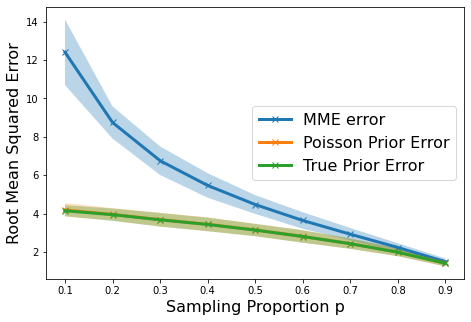

In [36]:
degree_plot_LOTP("ER_FILES","ER")

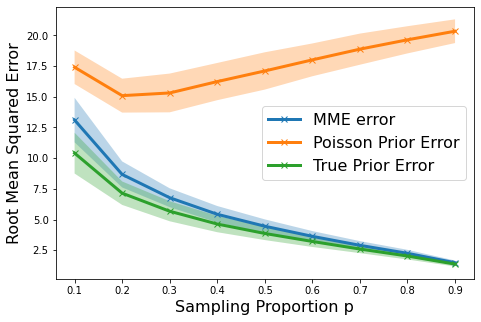

In [35]:
degree_plot_LOTP("BA_FILES","BA")

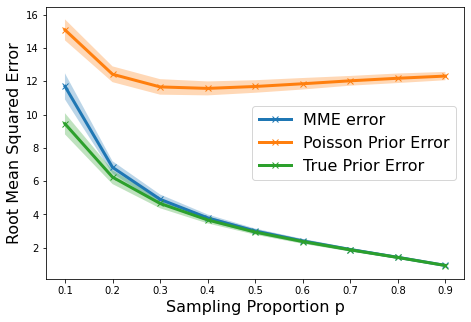

In [34]:
degree_plot_LOTP("FACEBOOK","FB")

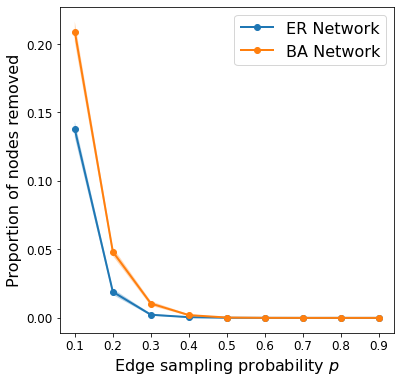

In [167]:
G = nx.read_gpickle("ER_FILES/REAL")
G_deg = degree_dict(G)
prange = np.linspace(0.1,0.9,9)
prange2 = np.linspace(0.1,1.0,10)
seed = 42

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel("Edge sampling probability $p$",fontsize=16)
ax.set_ylabel("Proportion of nodes removed",fontsize=16)

for f in ["ER","BA"]:

    nodes_means = np.zeros(9)
    nodes_sds = np.zeros(9)

    index=0
    for p in prange:
        data = np.zeros(50)
        for ex in range(50):
            fname = f+"_FILES/"+f+str(round(p,1))+"-"+str(ex)
            H = nx.read_gpickle(fname)
            data[ex]=len(H.nodes())/1000
        nodes_means[index]=data.mean()
        nodes_sds[index]=data.std()
        index+=1
    
    ax.plot(prange, 1.0-nodes_means, linewidth=2, marker='o', label=f+" Network")
    ax.fill_between(prange, 1.0-nodes_means - 0.5*nodes_sds, 1.0-nodes_means+0.5*nodes_sds, alpha=0.3)
    
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.legend(fontsize=16)
plt.savefig("NodesRemoved.pdf")
plt.show()